# Projet Lichess

_Traitements et données large échelle_

Zoé Marquis & Charlotte Kruzic

TODO : présenter les objectifs du projet, les différentes questions, les données utilisées


### Installation et importation des bibliothèques nécessaires

In [1]:
!pip install kagglehub

In [2]:
!pip install -q findspark

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import kagglehub

import findspark
from pyspark.sql import SparkSession

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [5]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"  # this is proper to Colab


## Préparation des données

Chargement des données, analyse exploratoire et prétraitement des données.

In [6]:
path = kagglehub.dataset_download("noobiedatascientist/lichess-september-2020-data")
print("Chemin vers le fichier du dataset : ", path)

Chemin vers le fichier du dataset :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3


In [7]:
files = os.listdir(path)
print("Fichiers du dataset : ", files)

Fichiers du dataset :  ['Sept_20_analysis.RDS', 'Sept_20_analysis.csv', 'Column information.txt']


In [8]:
filename = f"{path}/Sept_20_analysis.csv"
print("Nom du fichier : ", filename)

Nom du fichier :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Sept_20_analysis.csv


In [9]:
# voir le contenu du .txt
filename_txt = f"{path}/Column information.txt"
with open(filename_txt, 'r') as f:
    print(f.read())

GAME: Game ID (not from lichess.org)

BlackElo: Elo rating of the player with the black pieces

BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces

Date: Date the game was played

ECO: Game opening (ECO notation)

Event: Event where the game was played

Opening: Game opening

Result: Result of the game

	1-0 -- White victory
	0-1 -- Black victory
	1/2-1/2 -- Draw
	* -- Undecided
	
Site: URL of the game

Termination: Way the game terminated

	Time forfeit -- One of the players ran out of time
	Normal -- Game terminated with check mate
	Rules infraction -- Game terminated due to rule breaking
	Abandoned -- Game was abandoned
	
TimeControl: Timecontrol in seconds that was used for the game (Starting time: Increment) 

UTCTime: Time the game was played

WhiteElo: Elo rating of the player with the white pieces

WhiteRatingDiff: Rating change (gain/loss) after game conclusion for the player with the white pieces

Black_elo_category: ELO cate

## Spark

In [10]:
# Importation des éléments Spark
from pyspark.sql.functions import col, when, isnull, count, max as spark_max, countDistinct, row_number, split, concat_ws
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from collections import defaultdict

In [11]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [12]:
sc = spark.sparkContext
df_spark = spark.read.csv(filename, header=True, inferSchema=True)

In [13]:
df_spark.printSchema()

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

In [14]:
# nombre lignes
df_spark.count()

3739909

In [15]:
df_spark.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

## Préparation générale des données

#### Calcule des catégories

In [16]:
# TODO : Peut etre différencier les others (ceux supérieur ou inférieur aux bornes) ??

# Ajout des catégories ELO
# Catégorie ELO du joueur Noir
df_spark_plus = df_spark.withColumn("Black_ELO_category",
                              when((col("BlackElo") >= 1200) & (col("BlackElo") <= 1499), "occasional player")
                              .when((col("BlackElo") >= 1500) & (col("BlackElo") <= 1799), "good club player")
                              .when((col("BlackElo") >= 1800) & (col("BlackElo") <= 1999), "very good club player")
                              .when((col("BlackElo") >= 2000) & (col("BlackElo") <= 2399), "national and international level")
                              .when((col("BlackElo") >= 2400) & (col("BlackElo") <= 2800), "GMI, World Champions")
                              .otherwise("other")
                              )

# Catégorie ELO du joueur Blanc
df_spark_plus = df_spark_plus.withColumn("White_ELO_category",
                              when((col("WhiteElo") >= 1200) & (col("WhiteElo") <= 1499), "occasional player")
                              .when((col("WhiteElo") >= 1500) & (col("WhiteElo") <= 1799), "good club player")
                              .when((col("WhiteElo") >= 1800) & (col("WhiteElo") <= 1999), "very good club player")
                              .when((col("WhiteElo") >= 2000) & (col("WhiteElo") <= 2399), "national and international level")
                              .when((col("WhiteElo") >= 2400) & (col("WhiteElo") <= 2800), "GMI, World Champions")
                              .otherwise("other")
                              )

# Catégorie ELO moyenne des 2 joueurs
df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category", (col("BlackElo") + col("WhiteElo")) / 2)

df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category",
                              when((col("Avg_ELO_category") >= 1200) & (col("Avg_ELO_category") <= 1499), "occasional player")
                              .when((col("Avg_ELO_category") >= 1500) & (col("Avg_ELO_category") <= 1799), "good club player")
                              .when((col("Avg_ELO_category") >= 1800) & (col("Avg_ELO_category") <= 1999), "very good club player")
                              .when((col("Avg_ELO_category") >= 2000) & (col("Avg_ELO_category") <= 2399), "national and international level")
                              .when((col("Avg_ELO_category") >= 2400) & (col("Avg_ELO_category") <= 2800), "GMI, World Champions")
                              .otherwise("other"))

In [17]:
# vérifier combien de "other"
df_spark_plus.filter(col("Black_ELO_category") == "other").count()

476296

In [18]:
df_spark_plus.filter(col("White_ELO_category") == "other").count()

479718

## Question 1

Hypothèse : plus la catégorie est bonne plus le taux de fautes devrait logiquement diminuer

Q1: What is the rate of blunders, errors and inaccuracies per move, per level category (*) and on Blitz type games (Blitz type is by far the most played on these online sites). A game has two players, whose ELOs are most likely different. You will be able to classify a game into a category, either by considering the average ELO of both players, or by considering only the games where both players are in the same category.

In [19]:
# Filtre les parties avec un type de jeu Blitz
df_blitz = df_spark_plus.filter(col("Game_type") == "Blitz")

#### Calcule des taux

In [20]:
# Calcule taux de bourdes
df_blitz = df_blitz.withColumn("Black_blunders_rate", col("Black_blunders") / col("Total_moves")) \
                   .withColumn("White_blunders_rate", col("White_blunders") / col("Total_moves"))

In [21]:
# Calcule taux d'erreurs
df_blitz = df_blitz.withColumn("Black_errors_rate", col("Black_mistakes") / col("Total_moves")) \
                   .withColumn("White_errors_rate", col("White_mistakes") / col("Total_moves"))

In [22]:
# Calcule taux d'imprecisions
df_blitz = df_blitz.withColumn("Black_inaccuracies_rate", col("Black_inaccuracies") / col("Total_moves")) \
                   .withColumn("White_inaccuracies_rate", col("White_inaccuracies") / col("Total_moves"))

#### Classification des games avec moyenne des 2 joueurs

In [23]:
df_avg_elo_summary = df_blitz.groupBy("Avg_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [24]:
df_avg_elo_summary.show(5)

+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|    Avg_ELO_category|Avg_White_inaccuracies_rate|Avg_White_blunders_rate|Avg_Black_errors_rate|Avg_White_errors_rate|Avg_Black_blunders_rate|Avg_Black_inaccuracies_rate|
+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|GMI, World Champions|        0.03649314267507789|   0.015454990958813869| 0.033797322537345735| 0.033301912273222996|   0.016443676658494083|       0.038392670154764316|
|               other|       0.046071483010896905|    0.04768980684161655|  0.05582335797833772|  0.05445660451304556|    0.04843359364853215|       0.047421327592271655|
|very good club pl...|        0.04458924288017192|   0.024422100702977404| 0.045997908613240726| 0.045843799123494865|   0.025296756442037382|   

In [25]:
df_avg_elo_summary_pandas = df_avg_elo_summary.toPandas()

In [26]:
df_avg_elo_summary_pandas.isna().sum()

,0
Avg_ELO_category,0
Avg_White_inaccuracies_rate,0
Avg_White_blunders_rate,0
Avg_Black_errors_rate,0
Avg_White_errors_rate,0
Avg_Black_blunders_rate,0
Avg_Black_inaccuracies_rate,0


In [27]:
# TODO : Voir si on affiche les other

# Ordonner les catégories de joueurs
category_order = ["other", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions"]
df_avg_elo_summary_pandas['Avg_ELO_category'] = pd.Categorical(df_avg_elo_summary_pandas['Avg_ELO_category'],  categories=category_order,  ordered=True)
df_avg_elo_summary_pandas = df_avg_elo_summary_pandas.sort_values('Avg_ELO_category')


categories = df_avg_elo_summary_pandas['Avg_ELO_category']
error_types = ['Bourdes', 'Erreurs', 'Imprecisions']

# Données par type d'erreur et catégorie
blunders = df_avg_elo_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_avg_elo_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_avg_elo_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

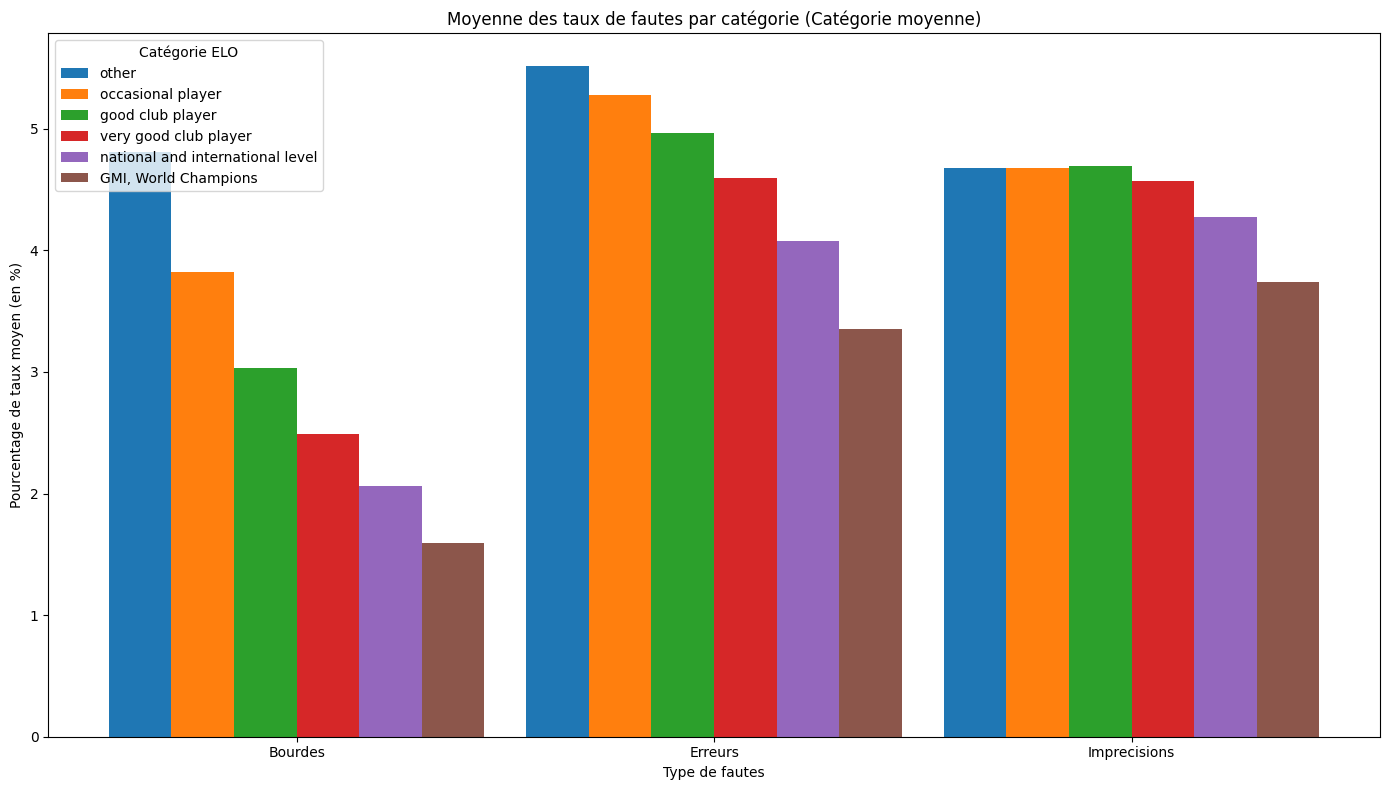

In [28]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.15

for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes') # TODO : Peut etre dire autrement
plt.ylabel('Pourcentage de taux moyen (en %)')
plt.title('Moyenne des taux de fautes par catégorie (Catégorie moyenne)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

#### Classification des games avec 2 joueurs de la même catégorie

In [29]:
df_same_category = df_blitz.filter(col("Black_ELO_category") == col("White_ELO_category"))

In [30]:
tot_blitz = df_blitz.count()
tot_same_cat = df_same_category.count()
print(f"Nombre de parties total : {tot_blitz}")
print(f"Nombre de parties avec 2 joueurs de la même catégorie : {tot_blitz}")
print(f"Pourcentage même catégorie : {tot_same_cat / tot_blitz * 100} %")

Nombre de parties total : 1812120
Nombre de parties avec 2 joueurs de la même catégorie : 1812120
Pourcentage même catégorie : 77.09274220250315 %


In [31]:
df_same_category_summary = df_same_category.groupBy("Black_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [32]:
df_same_category_summary_pandas = df_same_category_summary.toPandas()

In [33]:
# TODO : Voir si on affiche les other

# Ordonner les catégories de joueurs
category_order = ["other", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions"]
df_same_category_summary_pandas['Black_ELO_category'] = pd.Categorical(df_same_category_summary_pandas['Black_ELO_category'],  categories=category_order,  ordered=True)
df_same_category_summary_pandas = df_same_category_summary_pandas.sort_values('Black_ELO_category')


categories = df_same_category_summary_pandas['Black_ELO_category']
error_types = ['Bourdes', 'Erreurs', 'Imprecisions']

# Données par type d'erreur et catégorie (moyenne) # TODO : Voir si on fait autrement
blunders = df_same_category_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_same_category_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_same_category_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

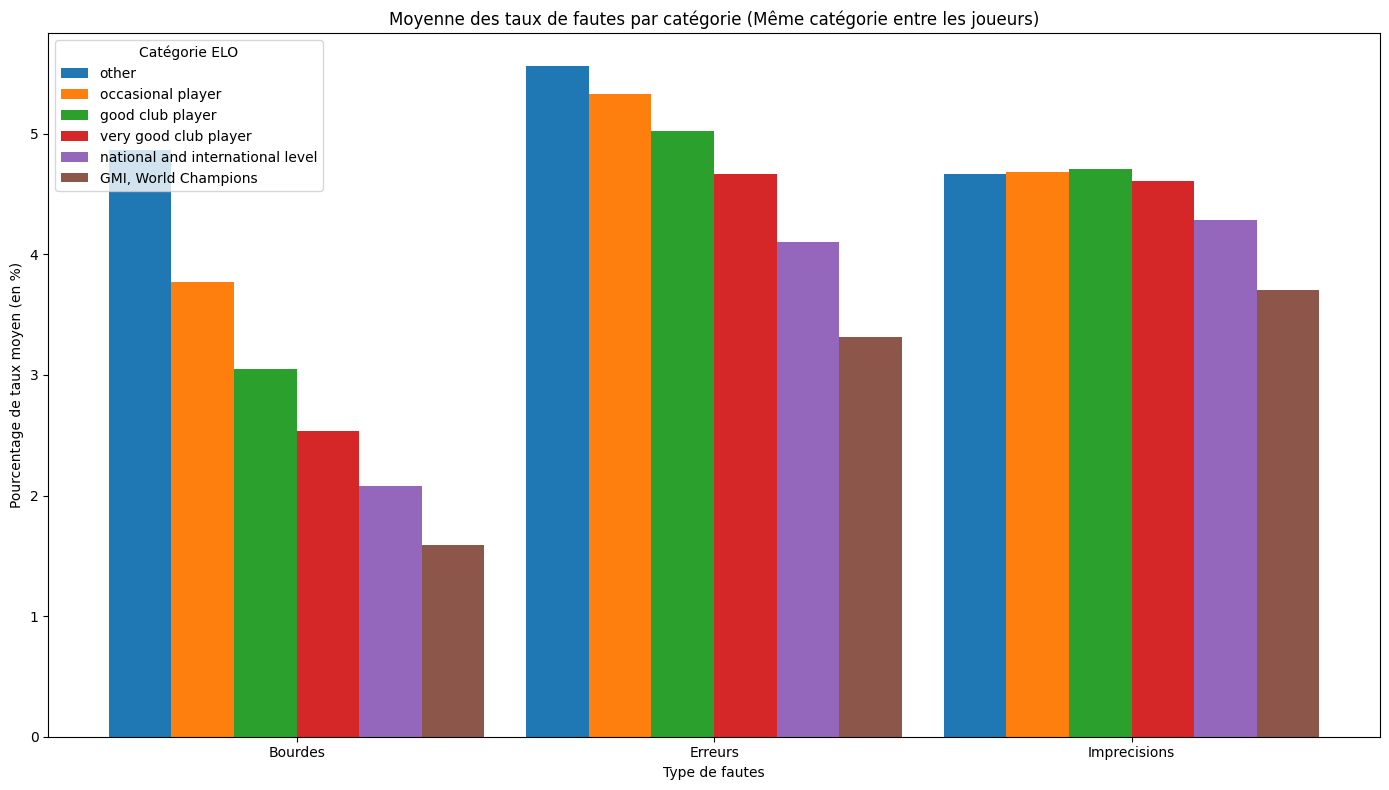

In [34]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.15
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes') # TODO : Peut etre dire autrement
plt.ylabel('Pourcentage de taux moyen (en %)')
plt.title('Moyenne des taux de fautes par catégorie (Même catégorie entre les joueurs)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

#### Résultats

- Même résultats par moyenne ou seulement les joueurs ayant la même catégorie.
- Tous les types de fautes ont tendances à dimuner plus le niveau augmente (taux diminue)
- En accord avec l'hypothèse

In [35]:
# TODO : Parler des résultats
# Peut etre refaire d'autres graphiques

### Question 2

Les Opening et ECO coressepondent aux ouvertures, nous regardons s'ils sont alignés.

In [36]:
# Nombre valeurs opening
print(f"Nombre de valeurs opening : {df_spark.select('Opening').distinct().count()}")
print(f"Nombre de valeurs ECO : {df_spark.select('ECO').distinct().count()}")

Nombre de valeurs opening : 2790
Nombre de valeurs ECO : 492


In [37]:
#  Checker si les colonnes ECO et Opening sont toujours alignées
alignment_check_1 = df_spark.groupBy("ECO").agg(countDistinct("Opening").alias("Unique_Openings"))
misaligned_rows_1 = alignment_check_1.filter(col("Unique_Openings") > 1)

In [38]:
# Afficher les résultats
if misaligned_rows_1.count() > 0:
    print("Il existe plusieurs Openings pour un code ECO.")
    misaligned_rows_1.show(5)
    print("Nombre de lignes : ", misaligned_rows_1.count())
else:
    print("Il existe un seul Opening pour un code ECO.")

Il existe plusieurs Openings pour un code ECO.
+---+---------------+
|ECO|Unique_Openings|
+---+---------------+
|B05|              4|
|B79|              2|
|A47|              3|
|E83|              3|
|B34|              3|
+---+---------------+
only showing top 5 rows

Nombre de lignes :  353


In [39]:
#  Checker si les colonnes ECO et Opening sont toujours alignées
alignment_check_2 = df_spark.groupBy("Opening").agg(countDistinct("ECO").alias("Unique_ECOs"))
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)

In [40]:
# Afficher les résultats
if misaligned_rows_2.count() > 0:
    print("Il existe plusieurs ECO pour un code Opening.")
    misaligned_rows_2.show(5)
    print("Nombre de lignes : ", misaligned_rows_2.count())
else:
    print("Il existe un seul ECO pour un code Opening.")

Il existe plusieurs ECO pour un code Opening.
+--------------------+-----------+
|             Opening|Unique_ECOs|
+--------------------+-----------+
|  St. George Defense|          2|
|Nimzo-Indian Defe...|          5|
|        Torre Attack|          2|
|   Caro-Kann Defense|          4|
|Sicilian Defense:...|          2|
+--------------------+-----------+
only showing top 5 rows

Nombre de lignes :  95


Beaucoup de Opening et ECO ne sont pas alignés, nous allons regarder si ce sont des erreurs.

In [41]:
# Filtrer pour les ouvertures ayant plusieurs ECO
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)
opening_eco_counts = df_spark.groupBy("Opening", "ECO").agg(count("*").alias("count"))
multiple_opening_eco_counts = misaligned_rows_2.join(opening_eco_counts, on="Opening", how="inner")
multiple_opening_eco_counts.orderBy("Opening", "count", ascending=False).show(truncate=False)


+------------------------------------------------------------------------+-----------+---+-----+
|Opening                                                                 |Unique_ECOs|ECO|count|
+------------------------------------------------------------------------+-----------+---+-----+
|Vienna Game: Vienna Gambit                                              |2          |C28|3648 |
|Vienna Game: Vienna Gambit                                              |2          |C25|1193 |
|Torre Attack                                                            |2          |A46|1704 |
|Torre Attack                                                            |2          |A48|1587 |
|St. George Defense                                                      |2          |B00|4265 |
|St. George Defense                                                      |2          |C00|690  |
|Slav Defense: Exchange Variation                                        |2          |D10|5637 |
|Slav Defense: Exchange Variat

Cela ne semble pas être des erreurs, il n'y a pas de ECO ou Opening largement dominant, nous allons donc garder ces éléments comme cela et les considérer comme 2 colonnes distinctes.

In [42]:
# TODO : Voir si on traite pour aligner ou si on fait juste avec Opening
# comme c'est fait actuellement

Nous avons pu constater que certaines configurations n'étaient joués que quelques fois et toujours gagnés par les Blancs. Cela ajoute un biais, et ne permet pas de déterminer correctement quel opening permet le plus de gagner. On obtenait plus de 3800 White_win_probability=1.

Nous avons donc décidé de concerver seulement les configurations avec un nombre de parties jouées élevées.

TODO : Dire combien on garde finalement et pourquoi

Q2: Win probability depending on opening:

- Q2a: With which opening does White have the best chance to win, by level category (*) and by type of game (Blitz, Fast, Classic).

In [43]:
# Calculer le nombre de parties pour chaque configuration
config_game_counts = df_spark_plus.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))
config_game_counts.orderBy("Total_games_count", ascending=False).show(5)

+--------------------+------------------+---------+-----------------+
|             Opening|White_ELO_category|Game_type|Total_games_count|
+--------------------+------------------+---------+-----------------+
|Queen's Pawn Game...| occasional player|    Blitz|            11963|
|Queen's Pawn Game...|  good club player|    Blitz|            11456|
|    Philidor Defense| occasional player|    Blitz|            10246|
|    Philidor Defense|  good club player|    Blitz|             9800|
|    Sicilian Defense|  good club player|    Blitz|             9702|
+--------------------+------------------+---------+-----------------+
only showing top 5 rows



In [44]:
# Nombre total de configurations uniques
print(f"Nombre total de configurations possibles : {config_game_counts.count()}")

Nombre total de configurations possibles : 43813


In [45]:
# Filtrer les configurations avec plus de 1000 parties jouées
# TODO : Voir si on adapte le nombre de parties (autre chose que 1000)
filtered_configurations = config_game_counts.filter(col("Total_games_count") > 1000)
filtered_configurations.orderBy("Total_games_count", ascending=False).show(5)
print(f"Nombre de configurations avec plus de 1000 parties jouées : {filtered_configurations.count()}")

+--------------------+------------------+---------+-----------------+
|             Opening|White_ELO_category|Game_type|Total_games_count|
+--------------------+------------------+---------+-----------------+
|Queen's Pawn Game...| occasional player|    Blitz|            11963|
|Queen's Pawn Game...|  good club player|    Blitz|            11456|
|    Philidor Defense| occasional player|    Blitz|            10246|
|    Philidor Defense|  good club player|    Blitz|             9800|
|    Sicilian Defense|  good club player|    Blitz|             9702|
+--------------------+------------------+---------+-----------------+
only showing top 5 rows

Nombre de configurations avec plus de 1000 parties jouées : 690


In [46]:
# On utilise que les configurations avec plus de 1000 parties
filtered_df = df_spark_plus.join( filtered_configurations.select("Opening", "White_ELO_category", "Game_type"), on=["Opening", "White_ELO_category", "Game_type"], how="inner")


In [47]:
# Récupération des parties voulues (blancs gagnes +  type de jeux Blitz, Fast, Classic)
df_white_wins = filtered_df.filter((col("Result") == "1-0") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"]))) #TODO : Fast et Classic n'existe pas j'ai mis Classical et Rapid
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [48]:
# Pour chaque ouverture, catégorie et type de jeu on calcule le nombre de victoires des blancs
df_white_wins_groupby = df_white_wins.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("White_win_count"))

# Pareil mais on calcule le total de parties jouées
df_total_games_groupby = df_total_games.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [49]:
df_white_wins_groupby.show(5)

+----------------+------------------+---------+---------------+
|         Opening|White_ELO_category|Game_type|White_win_count|
+----------------+------------------+---------+---------------+
|Alekhine Defense|  good club player|    Blitz|            519|
|Alekhine Defense| occasional player|    Blitz|            523|
|Bishop's Opening|  good club player|    Blitz|           1477|
|Bishop's Opening|  good club player|    Rapid|            834|
|Bishop's Opening| occasional player|    Blitz|           1563|
+----------------+------------------+---------+---------------+
only showing top 5 rows



In [50]:
df_total_games_groupby.show(5)

+----------------+------------------+---------+-----------------+
|         Opening|White_ELO_category|Game_type|Total_games_count|
+----------------+------------------+---------+-----------------+
|Alekhine Defense|  good club player|    Blitz|             1010|
|Alekhine Defense| occasional player|    Blitz|             1029|
|Bishop's Opening|  good club player|    Blitz|             2953|
|Bishop's Opening|  good club player|    Rapid|             1842|
|Bishop's Opening| occasional player|    Blitz|             3494|
+----------------+------------------+---------+-----------------+
only showing top 5 rows



In [51]:
# Calcule de la probabilité de gagner en fonction de l'ouverture
df_opening_stats = df_white_wins_groupby.join(df_total_games_groupby, on=["Opening", "White_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("White_win_probability", col("White_win_count") / col("Total_games_count"))

In [52]:
df_opening_stats.show(5)

+----------------+------------------+---------+---------------+-----------------+---------------------+
|         Opening|White_ELO_category|Game_type|White_win_count|Total_games_count|White_win_probability|
+----------------+------------------+---------+---------------+-----------------+---------------------+
|Alekhine Defense|  good club player|    Blitz|            519|             1010|   0.5138613861386139|
|Alekhine Defense| occasional player|    Blitz|            523|             1029|   0.5082604470359572|
|Bishop's Opening|  good club player|    Blitz|           1477|             2953|   0.5001693193362682|
|Bishop's Opening|  good club player|    Rapid|            834|             1842|   0.4527687296416938|
|Bishop's Opening| occasional player|    Blitz|           1563|             3494|  0.44733829421866056|
+----------------+------------------+---------+---------------+-----------------+---------------------+
only showing top 5 rows



In [53]:
df_opening_stats.count()

548

In [54]:
# Récupération du meilleur opening pour chaque categorie-type
window_spec = Window.partitionBy("White_ELO_category", "Game_type").orderBy(col("White_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", row_number().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("White_ELO_category", "Game_type", "Opening", "White_win_probability")

In [55]:
best_openings.orderBy("White_ELO_category", "Game_type").show(truncate=False)

+--------------------------------+---------+---------------------------------------------+---------------------+
|White_ELO_category              |Game_type|Opening                                      |White_win_probability|
+--------------------------------+---------+---------------------------------------------+---------------------+
|good club player                |Blitz    |King's Pawn Game: McConnell Defense          |0.6738768718801996   |
|good club player                |Classical|Philidor Defense                             |0.6274154589371981   |
|good club player                |Rapid    |King's Pawn Game: McConnell Defense          |0.7159716758457907   |
|national and international level|Blitz    |Owen Defense                                 |0.5989628349178912   |
|national and international level|Rapid    |Queen's Pawn Game: Mason Attack              |0.5564263322884012   |
|occasional player               |Blitz    |King's Pawn Game: McConnell Defense          |0.6744

In [56]:
best_openings_pandas = best_openings.toPandas()

In [57]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["White_ELO_category"])

# Table pivot pour voir le meilleur opening pour chaque configuration
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="White_win_probability"
)

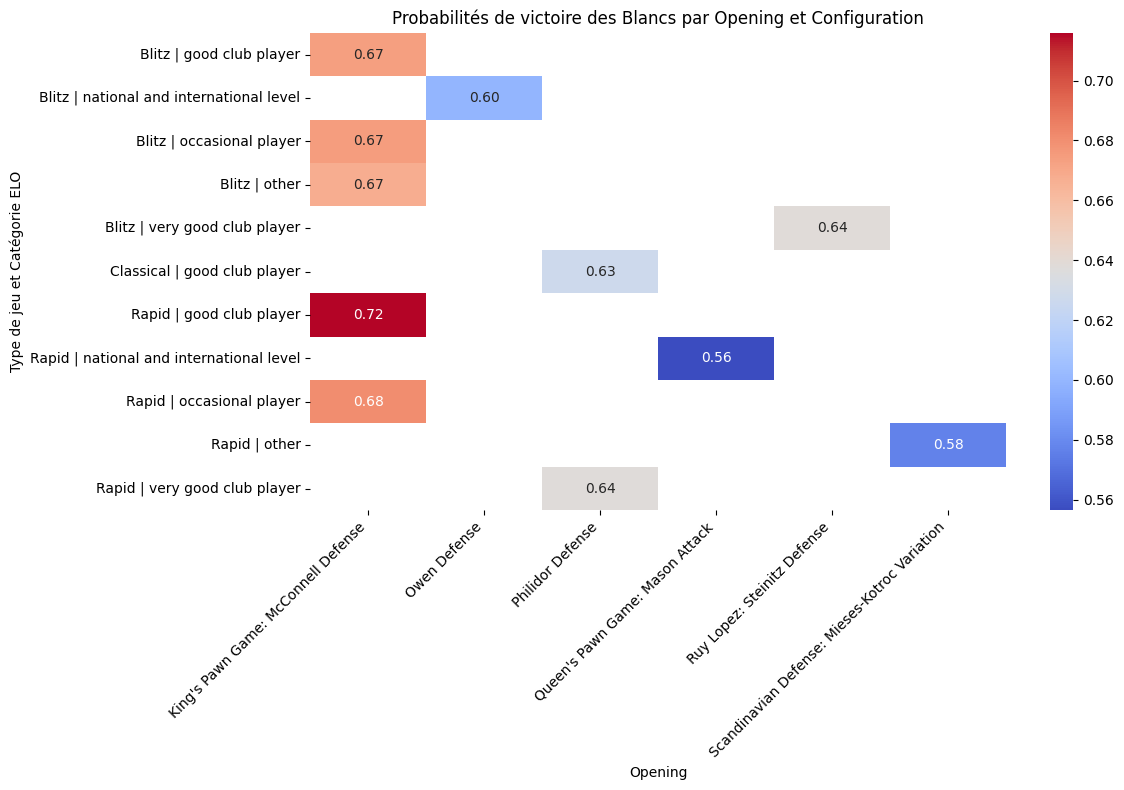

In [58]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Probabilités de victoire des Blancs par Opening et Configuration")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [59]:
# TODO : Voir comment on conclut ici en fonction de combien de parties min on utilise

# On voit que King's ... permet de gagner dans plusieurs conf

- Q2b: same question with black. You don't need to write again the same but only the results with black.

In [60]:
# TODO : Copier ce qu'il y a dans Q2a en remplacant White_ELO_category par Black_ELO_category
# A faire quand on aura décidé comment on fait

### Question 3

Q3: (difficult). Does a line of data in the file predict the outcome of the game (column Result), and with what
probability? In other words, can any of the variables, such as the number of errors (mistakes, blunders, inacurracies,
ts_blunders), the difference in ELO between the two players, etc., explain the outcome (win/loss)? You are free to
define explain as you wish. It can be a correlation, linear or not, or any other relationship that allows this prediction.

Note that the ELO is itself computed from a probability (normal distribution) of victory depending on the difference
in ELO of the two players. For instance, for a difference of 100 ELO points, the higher ranked player is expected to
win with probability 0.64. For a 200 points difference, it is 0.76.

As we have more data than the ELO difference, your prediction should be more accurate than that.

#### Observation des données

In [61]:
df_spark.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

#### Gestion valeurs NULL

In [62]:
# Calcule valeurs null par colonnes
null_counts = df_spark.select(
    *[
        count(when(col(c).isNull(), c)).alias(c)
        for c in df_spark.columns
    ]
)

null_counts.show()

+----+--------+---------------+----+---+-----+-------+------+----+-----------+-----------+-------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|Date|ECO|Event|Opening|Result|Site|Termination|TimeControl|UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Bl

Valeurs null dans les colonnes :
- BlackRatingDiff
- WhiteRatingDiff
- starting_time
- increment

##### Gestion starting_time et increment

In [63]:
# Même nombre null pour starting_time et increment, on vérifie que c'est aligné
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).count()

10344

In [64]:
# Afficher les type de game quand ces 2 colonnes sont NULL
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).select("Game_type").distinct().show()

+--------------+
|     Game_type|
+--------------+
|Correspondence|
+--------------+



In [65]:
# Afficher les parties avec type de jeu Correspondence et starting_time ou increment non null
df_spark.filter((col("Game_type") == "Correspondence") & (col("starting_time").isNotNull() | col("increment").isNotNull())).show()

+----+--------+---------------+----+---+-----+-------+------+----+-----------+-----------+-------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|Date|ECO|Event|Opening|Result|Site|Termination|TimeControl|UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Bl

In [66]:
# TODO : Les NULL sont normaux, on fait quoi ?

OK comme dans la doc

In [67]:
# Vérifier si TimeControl correspond bien à starting_time+increment
# Extraire starting_time et increment à partir de TimeControl
df_spark_check = df_spark.withColumn(
    "starting_time_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[0].cast("int"))
    .otherwise(None))

df_spark_check = df_spark_check.withColumn(
    "increment_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[1].cast("int"))
    .otherwise(None))

# Recréer TimeControl avec les colonnes extraites
df_spark_check = df_spark_check.withColumn(
    "TimeControl_reconstructed",
    when(col("starting_time_extracted").isNull() & col("increment_extracted").isNull(), "-")
    .otherwise(concat_ws("+", col("starting_time_extracted"), col("increment_extracted")))
)

# Comparer TimeControl avec la recréation
df_spark_check = df_spark_check.withColumn(
    "is_matching",
    col("TimeControl") == col("TimeControl_reconstructed")
)

# Checker les résultats
df_spark_check.select("TimeControl", "starting_time", "increment", "starting_time_extracted", "increment_extracted", "TimeControl_reconstructed", "is_matching").show(5)
mismatch_count = df_spark_check.filter(col("is_matching") == False).count()
print(f"Nombre de désalignements : {mismatch_count}")

+-----------+-------------+---------+-----------------------+-------------------+-------------------------+-----------+
|TimeControl|starting_time|increment|starting_time_extracted|increment_extracted|TimeControl_reconstructed|is_matching|
+-----------+-------------+---------+-----------------------+-------------------+-------------------------+-----------+
|      300+0|          300|        0|                    300|                  0|                    300+0|       true|
|      300+0|          300|        0|                    300|                  0|                    300+0|       true|
|      300+2|          300|        2|                    300|                  2|                    300+2|       true|
|      180+2|          180|        2|                    180|                  2|                    180+2|       true|
|      600+0|          600|        0|                    600|                  0|                    600+0|       true|
+-----------+-------------+---------+---

##### Gestion BlackRatingDiff et WhiteRatingDiff

In [68]:
# Même nombre null pour starting_time et increment, on vérifie que c'est aligné
df_spark.filter(col("BlackRatingDiff").isNull() & col("WhiteRatingDiff").isNull()).count()

12968

In [69]:
# pourcentage null
prc_missed = round(df_spark.filter(col("BlackRatingDiff").isNull() | col("WhiteRatingDiff").isNull()).count()/df_spark.count()*100,2)
print(f"Pourcentage de NULL : {prc_missed}%")

Pourcentage de NULL : 0.35%


In [70]:
# TODO : Virer les lignes avec des NULL

#### Conservation des colonnes utiles

In [71]:
# Colonnes inutiles
# - GAME : un ID, Date, Site, UTCTime, TimeControl

In [72]:
# Suppression colonnes inutiles
columns_to_drop = ["GAME", "Date", "Site", "UTCTime","TimeControl"]
df_spark_cleaned = df_spark.drop(*columns_to_drop)

In [73]:
# Observation des valeurs dans la colonne Result
result_counts = df_spark_cleaned.groupBy("Result").count()
result_counts.orderBy("count", ascending=False).show()

+-------+-------+
| Result|  count|
+-------+-------+
|    1-0|1863894|
|    0-1|1766395|
|1/2-1/2| 109548|
|      *|     72|
+-------+-------+



In [74]:
# TODO : Très peu de indéfini + prédit rien donc peut etre supprimer,
# revoir en fonction des résultats obtenus
df_spark_cleaned = df_spark_cleaned.filter(col("Result") != "*")

#### Gestion des données non numérique

In [75]:
# Observation des types des colonnes pour savoir comment les traiter
schema = df_spark_cleaned.schema
columns_by_type = defaultdict(list)

for field in schema:
    columns_by_type[str(field.dataType)].append(field.name)

for data_type, columns in columns_by_type.items():
    print(f"Type: {data_type}")
    print(f"Columns: {columns}\n")

Type: IntegerType()
Columns: ['BlackElo', 'BlackRatingDiff', 'WhiteElo', 'WhiteRatingDiff', 'starting_time', 'increment', 'Total_moves', 'Black_blunders', 'White_blunders', 'Black_mistakes', 'White_mistakes', 'Black_inaccuracies', 'White_inaccuracies', 'Black_inferior_moves', 'White_inferior_moves', 'Black_ts_moves', 'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders', 'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 'White_long_moves', 'Black_bad_long_moves', 'White_bad_long_moves', 'Game_flips', 'Game_flips_ts']

Type: StringType()
Columns: ['ECO', 'Event', 'Opening', 'Result', 'Termination', 'Black_elo_category', 'White_elo_category', 'Game_type']



In [76]:
# Afficher les valeurs pour les colonnes non numériques
columns_to_check = [
    'ECO', 'Event', 'Opening', 'Result', 'Termination',
    'Black_elo_category', 'White_elo_category', 'Game_type'
]

for column in columns_to_check:
    print(f"Valeurs possibles pour la colonne '{column}':")
    df_spark_cleaned.select(column).distinct().show(truncate=False)


Valeurs possibles pour la colonne 'ECO':
+---+
|ECO|
+---+
|B05|
|A23|
|E02|
|B79|
|B34|
|E83|
|A47|
|D81|
|E44|
|A76|
|B01|
|C22|
|A65|
|E56|
|B92|
|A46|
|C78|
|C95|
|C24|
|C77|
+---+
only showing top 20 rows

Valeurs possibles pour la colonne 'Event':
+---------------------------------------------------------------+
|Event                                                          |
+---------------------------------------------------------------+
|Rated Blitz tournament https://lichess.org/tournament/32Y8CIiO |
|Rated Blitz tournament https://lichess.org/tournament/Rxw6M8S8 |
|Rated Rapid tournament https://lichess.org/tournament/fzx79J4X |
|Rated Blitz tournament https://lichess.org/tournament/F9uklw6B |
|Rated Blitz tournament https://lichess.org/tournament/i08yaJaB |
|Rated Blitz tournament https://lichess.org/tournament/wLGCYyQq |
|Rated Bullet tournament https://lichess.org/tournament/alEGuHyE|
|Rated Blitz tournament https://lichess.org/tournament/gTxa9p5B |
|Rated Rapid tournam

In [77]:
# Extraire le type d'evenement
df_spark_cleaned = df_spark_cleaned.withColumn("Event_type", split(col("Event"), "https://")[0])
df_spark_cleaned.select("Event", "Event_type").show(5)

+----------------+----------------+
|           Event|      Event_type|
+----------------+----------------+
|Rated Blitz game|Rated Blitz game|
|Rated Blitz game|Rated Blitz game|
|Rated Blitz game|Rated Blitz game|
|Rated Blitz game|Rated Blitz game|
|Rated Rapid game|Rated Rapid game|
+----------------+----------------+
only showing top 5 rows



In [78]:
# Afficher les Event_type différents
df_spark_cleaned.select("Event_type").distinct().show(truncate=False)

+-----------------------------+
|Event_type                   |
+-----------------------------+
|Rated Classical game         |
|Rated Blitz tournament       |
|Rated Classical tournament   |
|Rated Rapid tournament       |
|Rated UltraBullet tournament |
|Rated Bullet tournament      |
|Rated Blitz game             |
|Rated Correspondence game    |
|Rated UltraBullet game       |
|Rated Rapid game             |
|Rated Bullet game            |
+-----------------------------+



In [79]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when

In [80]:
# Gérer les différentes colonnes non-numériques

# Beaucoup de valeurs : ECO et Opening
indexer_eco = StringIndexer(inputCol="ECO", outputCol="ECO_index")
indexer_opening = StringIndexer(inputCol="Opening", outputCol="Opening_index")

df_spark_cleaned = indexer_eco.fit(df_spark_cleaned).transform(df_spark_cleaned)
df_spark_cleaned = indexer_opening.fit(df_spark_cleaned).transform(df_spark_cleaned)

# Peu de valeurs : Termination, Black_elo_category, White_elo_category, Game_type, Event_type
# TODO : Voir si on fait One Hot mais apres c'est trop lourd pour convertir en df Pandas
columns_to_encode = ["Termination", "Black_elo_category", "White_elo_category", "Game_type", "Event_type"]

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    df_spark_cleaned = indexer.fit(df_spark_cleaned).transform(df_spark_cleaned)


# Colonne à retrouver : Result
df_spark_cleaned = df_spark_cleaned.withColumn(
    "Result_encoded",
    when(col("Result") == "1-0", 1)
    .when(col("Result") == "0-1", 0)
    .when(col("Result") == "1/2-1/2", -1)
    .otherwise(None)
)

In [81]:
df_spark_cleaned.printSchema()

root
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistakes: integer (nullable = true)
 |-- Black_inaccuracies: integer (nullable = true)
 |-- White_inaccuracies: integer (nullable = true)
 |-- Black_inferior_moves: integer (nullable = true)
 |-- Whit

In [82]:
df_spark_cleaned.show(5)

+--------+---------------+---+----------------+--------------------+------+------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+----------------+---------+-------------+-----------------+------------------------+------------------------+---------------+----------------+--------------+
|BlackElo|BlackRatingDiff|ECO|           Event|             Opening|Result| Termination|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_in

In [83]:
# Supprimer colonnes string remplacées si dessus
df_spark_cleaned_num = df_spark_cleaned.drop('ECO','Site','Opening','Termination','Black_elo_category','White_elo_category','Game_type','Result','Event','Event_type')

In [84]:
df_spark_cleaned_num.show(5)

+--------+---------------+--------+---------------+-------------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+---------+-------------+-----------------+------------------------+------------------------+---------------+----------------+--------------+
|BlackElo|BlackRatingDiff|WhiteElo|WhiteRatingDiff|starting_time|increment|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|Game_flips|Game_flips_ts|E

In [85]:
df_spark_cleaned_num.printSchema()

root
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistakes: integer (nullable = true)
 |-- Black_inaccuracies: integer (nullable = true)
 |-- White_inaccuracies: integer (nullable = true)
 |-- Black_inferior_moves: integer (nullable = true)
 |-- White_inferior_moves: integer (nullable = true)
 |-- Black_ts_moves: integer (nullable = true)
 |-- White_ts_moves: integer (nullable = true)
 |-- Black_ts_blunders: integer (nullable = true)
 |-- White_ts_blunders: integer (nullable = true)
 |-- Black_ts_mistakes: integer (nullable = true)
 |-- White_ts_mistake: integer (nullable = tr

#### Matrice de corrélation

In [86]:
# Calcule de la corrélation dans spark car pas assez de mémoire

In [87]:
# TODO : Gérer les valeurs NULL au dessus avant de pouvoir faire la suite

#### PCA

#### Modèle

### Questions supplémentaires

## Idées questions supplémentaires

- influence of time spent per move on errors
  - existe t il une corrélation entre le temps moyen par coup et le nombre d'erreurs ?
  - analyse par niveau et type de jeu

- distribtion of drawn games by opening and level
  - quelles ouvertures ont une probabilité plus élevée de conduire à une partie nulle ?
  - analyse des taux de parties nulles en fonciton de l'ouverture et des catégories ELO

- impact of ELO difference on game length
  - les parties avec une grande différence d'ELO durent-elles moins longtemps (en nombre de coups) ?

- most common mistakes by level
  - quels types d'erreurs sont les plus fréquents selon les catégories ELO ?
  - comparaison entre joueurs de niveau débutant et expert

- optimal strategy for specific openings
  - pour une ouverture donnée (à sélectionner manuellement), quelle est la stratégie optiale selon le niveau des joueurs ?